In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/face-mask-detection-dataset/submission.csv
/kaggle/input/face-mask-detection-dataset/train.csv
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/meta.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3758.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3335.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4660.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4543.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/5313.jpeg.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/3553.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations/4360.png.json
/kaggle/input/face-mask-detection-dataset/Medical mask/Medical 

**Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")


**Getting the Dataset**

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))    

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))

In [6]:
df.head(10)

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
5,6427.png,218,98,577,580,face_with_mask_incorrect
6,6427.png,278,386,582,582,mask_surgical
7,4591.png,239,9,522,342,face_with_mask
8,4591.png,255,159,491,341,mask_colorful
9,5392.jpg,261,0,444,257,face_other_covering


**Creating 'Mask' and 'No Mask' Class**

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)  

In [8]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

**An image from the Dataset**

AxesImage(54,36;334.8x217.44)
1


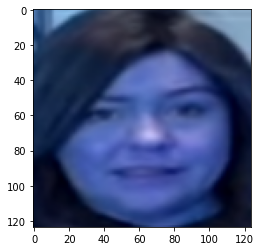

In [9]:
print(plt.imshow(X[11]))
print(Y[11])

In [10]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [11]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

**Convolutional Neural network**

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

**Training the Model**

In [15]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
143/143 [==============================] - 28s 144ms/step - loss: 0.5105 - accuracy: 0.8147 - val_loss: 0.3063 - val_accuracy: 0.8748
Epoch 2/50
143/143 [==============================] - 20s 137ms/step - loss: 0.2835 - accuracy: 0.8835 - val_loss: 0.2396 - val_accuracy: 0.9087
Epoch 3/50
143/143 [==============================] - 20s 140ms/step - loss: 0.2453 - accuracy: 0.8955 - val_loss: 0.2182 - val_accuracy: 0.9217
Epoch 4/50
143/143 [==============================] - 20s 138ms/step - loss: 0.2387 - accuracy: 0.9007 - val_loss: 0.2110 - val_accuracy: 0.9200
Epoch 5/50
143/143 [==============================] - 19s 132ms/step - loss: 0.2408 - accuracy: 0.8977 - val_loss: 0.2180 - val_accuracy: 0.9165
Epoch 6/50
143/143 [==============================] - 20s 141ms/step - loss: 0.2280 - accuracy: 0.9021 - val_loss: 0.2196 - val_accuracy: 0.9278
Epoch 7/50
143/143 [==============================] - 21s 143ms/step - loss: 0.2216 - accuracy: 0.9039 - val_loss: 0.2086 - val_ac

**Accuracy on training set: 94.54% and Accuracy on Validation set: 95.04%**